# Import Libraries

In [1]:
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_datasets as tfds
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Input, Dropout
from keras.layers import *
import tensorflow_probability as tfp
from tensorflow.keras.models import Sequential
from tensorflow.keras import backend as K

from sklearn.model_selection import KFold

import numpy as np
from numpy import linalg as LA
from itertools import product
import scipy
import random

import os
import gc
import matplotlib.pyplot as plt
from tqdm import tqdm

2024-06-01 17:47:47.413807: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-01 17:47:47.413942: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-01 17:47:47.579073: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Hyperparameters

In [2]:
# dimension of input image
rows, cols= 200, 200

# number of neurons as number of Rule will be produce
n_neurons = 100

# number of features feed to fuzzy Inference Layer
n_feature = 9

# based of article
batch_size = 63

# Data Preprocessing

In [5]:
def load_data(address_ds, size_batch, validation_split=0.2):
    # Define image size and batch size
    batch_size = size_batch

    train_ds = tf.keras.utils.image_dataset_from_directory(
        address_ds,
        seed=100,
        image_size=(rows, cols),
        batch_size=batch_size,
        validation_split=validation_split,
        subset="training"
    )
    
    test_ds = tf.keras.utils.image_dataset_from_directory(
        address_ds,
        seed=100,
        image_size=(rows, cols),
        batch_size=batch_size,
        validation_split=validation_split,
        subset="validation"
    )
    
    
    return train_ds, test_ds


address_ds = "/kaggle/input/diamond-images-dataset/web_scraped/"
batch_size = 32  # Define your batch size
train_ds, test_ds = load_data(address_ds, batch_size, validation_split=0.2)

Found 48765 files belonging to 8 classes.
Using 39012 files for training.
Found 48765 files belonging to 8 classes.
Using 9753 files for validation.


In [17]:
normalized_train_images = train_images / 255.0

In [6]:
# see class names
class_names = train_ds.class_names
print('Diamond dataset:{}'.format(class_names))

Diamond dataset:['cushion', 'emerald', 'heart', 'marquise', 'oval', 'pear', 'princess', 'round']


In [7]:
for image, label in train_ds.take(1):
    train_images = image.numpy()
    train_labels = np.reshape(label.numpy(), (-1,1))

In [40]:
for image, label in test_ds.take(1):
    test_images = image.numpy()
    test_labels = np.reshape(label.numpy(), (-1,1))

In [8]:
# shape of the training and test set
print("train_images", train_images.shape)
print("test_images", train_labels.shape)
     

train_images (32, 200, 200, 3)
test_images (32, 1)


# Fuzzy block

In [9]:
class fuzzy_inference_block(tf.keras.layers.Layer):
    def __init__(self, output_dim, i_fmap, mu, sigma):

        self.output_dim = output_dim
        self.index = i_fmap
        self.mu = mu
        self.sigma = sigma

        super(fuzzy_inference_block, self).__init__()

    def build(self, input_shape):
        self.mu_map = fRules_sigma * self.mu
        self.sigma_map = tf.ones((n_feature, self.output_dim)) * self.sigma
        

        super().build(input_shape)

    def call(self, inputs):
        fMap = inputs[:,n_feature*(self.index):n_feature*(self.index+1)]
        # create variables for processing
        aligned_x = K.repeat_elements(K.expand_dims(fMap, axis=-1), self.output_dim, -1)
        aligned_c = self.mu_map
        aligned_s = self.sigma_map


        # calculate output of each neuron (fuzzy rule)
        phi = K.exp(-K.sum(K.square(aligned_x - aligned_c) / (2 * K.square(aligned_s)),
                           axis=-2, keepdims=False))
        return phi

In [10]:
def fcnn(img_path='network_image.png', n_femap=4, stride=2, mu=3.0, sigma=1.2, dropout=True):
    # if stride is 3 => size of feature map will be 2x2
    # elif stride is 2 => size of feature map will be 3x3

    num_classes = 8

    inp = Input(shape=[rows, cols, 3])

    conv1 = Conv2D(20, (6, 6), padding='valid', strides=(3,3), activation='relu')(inp)
    conv1 = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(conv1)

    conv2 = Conv2D(40, (6, 6), padding='valid', strides=(2,2), activation='relu')(conv1)
    conv2 = MaxPooling2D((2, 2), strides=(1, 1), padding='same')(conv2)

    conv3 = Conv2D(40, (3, 3), padding='valid', strides=(2,2), activation='relu')(conv2)
    conv3 = MaxPooling2D((2, 2), strides=(1, 1), padding='same')(conv3)

    conv4 = Conv2D(40, (3, 3), padding='valid', strides=(2,2), activation='relu')(conv3)
    conv4 = MaxPooling2D((2, 2), strides=(1, 1), padding='same')(conv4)

    conv5 = Conv2D(n_femap, (4, 4), padding='same', strides=(stride,stride), activation='relu')(conv4)
    if dropout:
        conv5 = Dropout(0.2)(conv5)

    fMaps = Flatten()(conv5)


    fuzzy_inference = []
    for i in tqdm(range(n_femap)):
        f_block = fuzzy_inference_block(output_dim=n_neurons, i_fmap=i, mu=mu, sigma=sigma)(fMaps)
        fuzzy_inference.append(f_block)
    merged = concatenate(fuzzy_inference, axis=1)

    out = Dense(num_classes, activation='softmax')(merged)

    model = tf.keras.Model(inp, out)
    
    return model

In [11]:
def cnn(img_path='network_image.png', n_femap=4, stride=2, mu=3.0, sigma=1.2, dropout=False):
    num_classes = 8

    inputs = tf.keras.layers.Input(shape=[rows, cols, 3])

    tower_1 = Conv2D(20, (6, 6), padding='valid', strides=(3,3), activation='relu')(inputs)
    tower_1 = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(tower_1)

    tower_2 = Conv2D(40, (6, 6), padding='valid', strides=(2,2), activation='relu')(tower_1)
    tower_2 = MaxPooling2D((2, 2), strides=(1, 1), padding='same')(tower_2)

    tower_3 = Conv2D(40, (3, 3), padding='valid', strides=(2,2), activation='relu')(tower_2)
    tower_3 = MaxPooling2D((2, 2), strides=(1, 1), padding='same')(tower_3)

    tower_4 = Conv2D(40, (3, 3), padding='valid', strides=(2,2), activation='relu')(tower_3)
    tower_4 = MaxPooling2D((2, 2), strides=(1, 1), padding='same')(tower_4)

    tower_5 = Conv2D(80, (4, 4), padding='same', strides=(3,3), activation='relu')(tower_4)
    tower_5= Dropout(0.2)(tower_5)

    tower_5 = Flatten()(tower_5)

    out = Dense(100, activation='relu')(tower_5)
    out = Dense(num_classes, activation='softmax')(out)

    model = tf.keras.Model(inputs, out)
    return model

In [12]:
# to get all permutaion
fRules = list(product([-1.0,0.0,1.0], repeat=n_feature)) 

# based on article just 100 of them are needed
out_fRules = random.sample(fRules, n_neurons)

fRules_sigma = K.transpose(out_fRules)

In [13]:
model = fcnn(n_femap=80)

100%|██████████| 80/80 [00:01<00:00, 48.09it/s]


In [14]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 200, 200,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 65, 65,    │      2,180 │ input_layer[0][0] │
│                     │ 20)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 65, 65,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 20)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 30, 30,    │     28,840 │ max_pooling2d[0]… │
│                     │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 30, 30,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 14, 14,    │     14,440 │ max_pooling2d_1[… │
│                     │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 14, 14,    │          0 │ conv2d_2[0][0]    │
│ (MaxPooling2D)      │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 6, 6, 40)  │     14,440 │ max_pooling2d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 6, 6, 40)  │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 3, 3, 80)  │     51,280 │ max_pooling2d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 3, 3, 80)  │          0 │ conv2d_4[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 720)       │          0 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fuzzy_inference_bl… │ (None, 100)       │          0 │ flatten[0][0]     │
│ (fuzzy_inference_b… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fuzzy_inference_bl… │ (None, 100)       │          0 │ flatten[0][0]     │
│ (fuzzy_inference_b… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fuzzy_inference_bl… │ (None, 100)       │          0 │ flatten[0][0]     │
│ (fuzzy_inference_b… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fuzzy_inference_bl… │ (None, 100)       │          0 │ flatten[0][0]     │
│ (fuzzy_inference_b… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fuzzy_inference_bl… │ (None, 100)       │          0 │ flatten[0][0]     │
│ (fuzzy_inference_b… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fuzzy_inference_bl… │ (None, 100)       │          0 │ flatten[0][0]     │
│ (fuzzy_inference_b… │                   │            │                 

 Total params: 175,188 (684.33 KB)

 Trainable params: 175,188 (684.33 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
kfold = KFold(n_splits=10, shuffle=True)

In [22]:
def train_model(model_func, train_images, train_labels, no_epochs=30, optimizer='adam', n_femap=80, stride=2, mu=3.0, sigma=1.2, dropout=True, show=True):
    foldperf = {}
    fold_no = 1
    acc_per_fold = []
    loss_per_fold = []

    model = scores = history = 1

    for test, train in kfold.split(train_images, train_labels):


        del history
        del scores
        del model

        tf.keras.backend.clear_session()

        gc.collect()

        # Define the model architecture 
        model = model_func(n_femap=n_femap, stride=stride, mu=mu, sigma=sigma, dropout=dropout)
        # Compile model
        model.compile(optimizer=optimizer,
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                  metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

        # Generate a print
        print('------------------------------------------------------------------------')
        print(f'Training for fold {fold_no} ...')

        # Fit on data for 30 epochs
        history = model.fit(train_images[train], train_labels[train],
                  batch_size=batch_size,
                  epochs=no_epochs,
                  verbose=show)

        # Generate generalization metrics
        scores = model.evaluate(train_images[test], train_labels[test], verbose=0)

        print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
        acc_per_fold.append(scores[1] * 100)
        loss_per_fold.append(scores[0])

        # Increase fold number
        fold_no = fold_no + 1

        foldperf['fold{}'.format(fold_no)] = history  

        # gc.collect()

        

    return foldperf, [loss_per_fold, acc_per_fold]

foldperf_temp, scores_temp = train_model(fcnn, normalized_train_images, train_labels,no_epochs=10, show=True)


100%|██████████| 80/80 [00:01<00:00, 44.12it/s]


------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 20s 20s/step - loss: 2.0793 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 2.0777 - sparse_categorical_accuracy: 0.5000
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 2.0757 - sparse_categorical_accuracy: 0.2500
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 2.0715 - sparse_categorical_accuracy: 0.2500
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 2.0647 - sparse_categorical_accuracy: 0.0000e+00
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 2.0647 - sparse_categorical_accuracy: 0.0000e+00
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - loss: 2.0533 - sparse_categorical_accuracy: 0.2500
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - loss: 2.0501 - sparse_categorical_accuracy: 0.2500
Epoch 9/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 2.0386 - sparse

100%|██████████| 80/80 [00:01<00:00, 47.69it/s]


------------------------------------------------------------------------
Training for fold 2 ...
Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 20s 20s/step - loss: 2.0792 - sparse_categorical_accuracy: 0.5000
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 2.0772 - sparse_categorical_accuracy: 0.5000
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: 2.0747 - sparse_categorical_accuracy: 0.5000
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - loss: 2.0706 - sparse_categorical_accuracy: 0.5000
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 2.0634 - sparse_categorical_accuracy: 0.5000
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: 2.0422 - sparse_categorical_accuracy: 0.5000
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: 2.0385 - sparse_categorical_accuracy: 0.5000
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - loss: 2.0149 - sparse_categorical_accuracy: 0.5000
Epoch 9/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - loss: 2.0021 - sparse_categorical

100%|██████████| 80/80 [00:01<00:00, 48.16it/s]


------------------------------------------------------------------------
Training for fold 3 ...
Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 20s 20s/step - loss: 2.0795 - sparse_categorical_accuracy: 0.3333
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 2.0775 - sparse_categorical_accuracy: 0.3333
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 2.0753 - sparse_categorical_accuracy: 0.3333
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 2.0726 - sparse_categorical_accuracy: 0.3333
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - loss: 2.0677 - sparse_categorical_accuracy: 0.6667
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 2.0616 - sparse_categorical_accuracy: 0.6667
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 2.0414 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 2.0295 - sparse_categorical_accuracy: 0.3333
Epoch 9/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: 2.0130 - sparse_categor

100%|██████████| 80/80 [00:01<00:00, 48.33it/s]


------------------------------------------------------------------------
Training for fold 4 ...
Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 19s 19s/step - loss: 2.0791 - sparse_categorical_accuracy: 0.3333
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - loss: 2.0769 - sparse_categorical_accuracy: 0.3333
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 2.0745 - sparse_categorical_accuracy: 0.3333
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 2.0712 - sparse_categorical_accuracy: 0.6667
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 2.0640 - sparse_categorical_accuracy: 0.6667
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 2.0517 - sparse_categorical_accuracy: 0.6667
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 2.0295 - sparse_categorical_accuracy: 0.6667
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 2.0283 - sparse_categorical_accuracy: 0.3333
Epoch 9/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 2.0079 - sparse_categorica

100%|██████████| 80/80 [00:01<00:00, 45.82it/s]


------------------------------------------------------------------------
Training for fold 5 ...
Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 20s 20s/step - loss: 2.0793 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 2.0770 - sparse_categorical_accuracy: 0.3333
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - loss: 2.0744 - sparse_categorical_accuracy: 0.6667
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 2.0704 - sparse_categorical_accuracy: 0.6667
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: 2.0580 - sparse_categorical_accuracy: 0.6667
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 2.0402 - sparse_categorical_accuracy: 0.6667
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 2.0397 - sparse_categorical_accuracy: 0.6667
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - loss: 2.0158 - sparse_categorical_accuracy: 0.6667
Epoch 9/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 1.9876 - sparse_categ

100%|██████████| 80/80 [00:01<00:00, 46.84it/s]


------------------------------------------------------------------------
Training for fold 6 ...
Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 20s 20s/step - loss: 2.0798 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - loss: 2.0780 - sparse_categorical_accuracy: 0.3333
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 2.0762 - sparse_categorical_accuracy: 0.3333
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 2.0740 - sparse_categorical_accuracy: 0.3333
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: 2.0708 - sparse_categorical_accuracy: 0.3333
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - loss: 2.0642 - sparse_categorical_accuracy: 0.6667
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 2.0554 - sparse_categorical_accuracy: 0.3333
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 2.0525 - sparse_categorical_accuracy: 0.0000e+00
Epoch 9/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 2.0487 - sparse_c

100%|██████████| 80/80 [00:01<00:00, 46.61it/s]


------------------------------------------------------------------------
Training for fold 7 ...
Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 19s 19s/step - loss: 2.0796 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - loss: 2.0775 - sparse_categorical_accuracy: 0.3333
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - loss: 2.0753 - sparse_categorical_accuracy: 0.3333
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 2.0728 - sparse_categorical_accuracy: 0.3333
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - loss: 2.0689 - sparse_categorical_accuracy: 1.0000
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: 2.0636 - sparse_categorical_accuracy: 0.3333
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 2.0378 - sparse_categorical_accuracy: 1.0000
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 2.0184 - sparse_categorical_accuracy: 0.6667
Epoch 9/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: 2.0019 - sparse_categ

100%|██████████| 80/80 [00:01<00:00, 43.62it/s]


------------------------------------------------------------------------
Training for fold 8 ...
Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 20s 20s/step - loss: 2.0793 - sparse_categorical_accuracy: 0.3333
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 2.0775 - sparse_categorical_accuracy: 0.3333
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 2.0756 - sparse_categorical_accuracy: 0.3333
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: 2.0729 - sparse_categorical_accuracy: 0.3333
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 2.0689 - sparse_categorical_accuracy: 0.3333
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 2.0573 - sparse_categorical_accuracy: 0.3333
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 2.0572 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: 2.0375 - sparse_categorical_accuracy: 0.3333
Epoch 9/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: 2.0151 - sparse_categor

100%|██████████| 80/80 [00:01<00:00, 41.61it/s]


------------------------------------------------------------------------
Training for fold 9 ...
Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 20s 20s/step - loss: 2.0790 - sparse_categorical_accuracy: 0.3333
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: 2.0771 - sparse_categorical_accuracy: 0.3333
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - loss: 2.0742 - sparse_categorical_accuracy: 0.3333
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 2.0691 - sparse_categorical_accuracy: 0.3333
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 2.0577 - sparse_categorical_accuracy: 0.3333
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 2.0509 - sparse_categorical_accuracy: 0.3333
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 2.0369 - sparse_categorical_accuracy: 0.0000e+00
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 2.0208 - sparse_categorical_accuracy: 0.3333
Epoch 9/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 2.0249 - sparse_categori

100%|██████████| 80/80 [00:01<00:00, 44.54it/s]


------------------------------------------------------------------------
Training for fold 10 ...
Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 20s 20s/step - loss: 2.0796 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 2.0770 - sparse_categorical_accuracy: 1.0000
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - loss: 2.0742 - sparse_categorical_accuracy: 1.0000
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - loss: 2.0692 - sparse_categorical_accuracy: 1.0000
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - loss: 2.0603 - sparse_categorical_accuracy: 1.0000
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 2.0378 - sparse_categorical_accuracy: 1.0000
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 2.0345 - sparse_categorical_accuracy: 1.0000
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 2.0020 - sparse_categorical_accuracy: 1.0000
Epoch 9/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - loss: 1.9842 - sparse_categ

In [23]:
foldperf_temp_cnn, scores_temp_cnn = train_model(cnn, normalized_train_images, train_labels,no_epochs=10, show=True)

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 2.1748 - sparse_categorical_accuracy: 0.0000e+00
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 2.0467 - sparse_categorical_accuracy: 0.0000e+00
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 1.9727 - sparse_categorical_accuracy: 0.7500
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 1.6992 - sparse_categorical_accuracy: 0.7500
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 1.3587 - sparse_categorical_accuracy: 0.7500
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 1.1960 - sparse_categorical_accuracy: 0.7500
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 1.0898 - sparse_categorical_accuracy: 0.7500
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: 0.9231 - sparse_categorical_accuracy: 0.7500
Epoch 9/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.6401 - sparse_categ

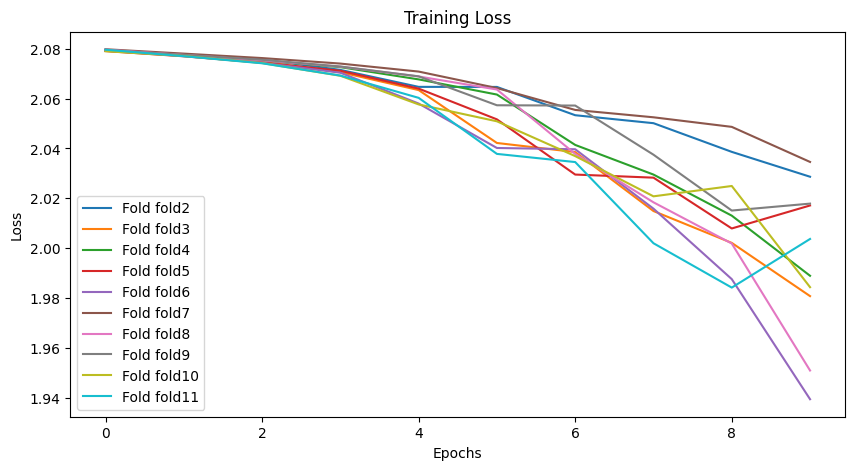

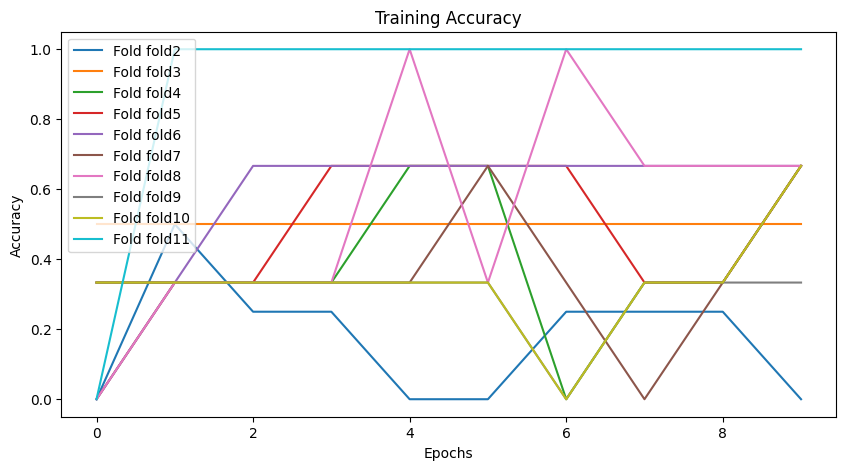

In [38]:
import matplotlib.pyplot as plt

def plot_metrics(foldperf, scores):
    loss_per_fold, acc_per_fold = scores
    # Plot loss
    plt.figure(figsize=(10, 5))
    for fold, history in foldperf.items():
        plt.plot(history.history['loss'], label=f'Fold {fold}')
    plt.title('Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Plot accuracy
    plt.figure(figsize=(10, 5))
    for fold, history in foldperf.items():
        plt.plot(history.history['sparse_categorical_accuracy'], label=f'Fold {fold}')
    plt.title('Training Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

# Use the function to plot
plot_metrics(foldperf_temp, scores_temp)


In [47]:
import tensorflow as tf

def normalize(image, label):
    # Normalize the image to [0, 1]
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

def load_data(address_ds, size_batch, validation_split=0.2):
    # Define image size and batch size
    batch_size = size_batch

    train_ds = tf.keras.utils.image_dataset_from_directory(
        address_ds,
        seed=100,
        image_size=(rows, cols),
        batch_size=batch_size,
        validation_split=validation_split,
        subset="training"
    )
    
    test_ds = tf.keras.utils.image_dataset_from_directory(
        address_ds,
        seed=100,
        image_size=(rows, cols),
        batch_size=batch_size,
        validation_split=validation_split,
        subset="validation"
    )
    
    # Normalize the datasets
    train_ds = train_ds.map(normalize)
    test_ds = test_ds.map(normalize)
    
    return train_ds, test_ds

# Assuming you have defined rows and cols
rows, cols = 224, 224  # Example image size, replace with actual size

address_ds = "/kaggle/input/diamond-images-dataset/web_scraped/"
batch_size = 64  # Define your batch size
train_ds_norm, test_ds_norm = load_data(address_ds, batch_size, validation_split=0.2)


Found 48765 files belonging to 8 classes.
Using 39012 files for training.
Found 48765 files belonging to 8 classes.
Using 9753 files for validation.
